# Kitchen Utensils Classifier Training Notebook

In this notebook, we go through a series of steps to train a custom classifier for kitchen utensils. We will rely on an Inception-v3 pre-trained model for features extraction and perform transfer learning.

## Import Required Dependencies

Below we import the required dependencies for this notebook

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import time

from collections import OrderedDict
import torch
from torchvision import transforms, models
import matplotlib.pyplot as plt
import dataset_interfaces
import training_helper
# To attempt to get reproducible results
import random
random.seed(42)
torch.manual_seed(42)

## Defining Interface to Load Dataset

In this section, we define a custom interface to load the images from our dataset. We have implemented most of the code for this interface in the separate python module called 'dataset_interfaces'.

### Define Transformations to Apply to Images to Load

The inception_v3 pretrained model requires the input to be 299x299 images with 3 channels (RGB). Each color channel was normalized separately, the means are [0.485, 0.456, 0.406] and deviation is [0.229, 0.224, 0.225], which we will define below. 

To augment the data seeen by our model in each batch of the training process, we also perform random rotation (with a maximum of 30 degrees) and random horizontal flips. The images are initially resized to 320x320 and then cropped in their center to obtain the required 299x299 size. 

In [2]:
# For training, we apply special transformations like random rotation and horizontal flip to to data augmentation
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize((320, 320)),
                                       transforms.CenterCrop(299),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize((320, 320)),
                                      transforms.CenterCrop(299),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

### Defining Interface and Data Loaders
We have created a helper module called *'dataset_interfaces.py'* to aid with the interfacing to the dataset. We are relying in Google Collab to accelerate the training process. If this is not being used, change the flag below to False.

In [3]:
# Set this flag to indicate if we are using Google Collab for the training process
using_collab = True

Below we define some important parameters for the training process. The train will be performed in batches of 64 images. Besides, 20% of the training data will be used for validation as the training process runs. We also define the name of the classes in the expected order they will be loaded.

In [4]:
# Defining general parameters for the data loading
batch_size = 64
# 20% of the training data will be used to validate the model as it trains
# This helps visualizing if it is overfitting and to save the model with the lowest loss for validation
validation_size=0.2
# Name of the classes to load
classes_names = ['BOTTLE_OPENER', 'DINNER_FORK', 'DINNER_KNIFE', 'FISH_SLICE', 'KITCHEN_KNIFE', 'LADLE', 
                 'POTATO_PEELER', 'SPATULA', 'SPOON', 'WHISK']
num_classes = len(classes_names)

When using collab, we need to retrieve the images from a google drive account, where the images are expected to be saved. In this case we have written a custom dataset interface that maps the image files into a virtual *H5* file. This is used to accelerate the training process, since loading from drive while training is a very slow process.

In [5]:
if using_collab:
    # We are going to mount google drive to interface with the dataset
    from google.colab import drive
    drive.mount('/content/drive')
    # Ensure the dataset is uploaded to the next location in your google drive account
    dataset_dir = '/content/drive/My Drive/Colab Notebooks/dataset'
    
    # Since loading images from drive every time is very slow, we load the images into a memory-mapped H5 file
    # The created interface is used for this purpose
    dataset_int = dataset_interfaces.H5FileDatasetInterface(dataset_dir, 
                                                            classes_names=classes_names,
                                                            batch_size=batch_size, 
                                                            validation_size=validation_size,
                                                            train_transform=train_transforms,
                                                            test_transform=test_transforms,
                                                            images_size=320)
else:
    # We are not using collab. Running in the local computer instead
    # Just give relative path to dataset directory
    dataset_dir = '../dataset'
    
    # We will use an interface that can interact with the images in the folder
    dataset_int = dataset_interfaces.ImgFolderDatasetInterface(dataset_dir, 
                                                               classes_names=classes_names,
                                                               batch_size=batch_size, 
                                                               validation_size=validation_size,
                                                               train_transform=train_transforms,
                                                               test_transform=test_transforms)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Creating h5 file 'data_training.h5' with 799 samples from path '/content/drive/My Drive/Colab Notebooks/dataset/train'
New class idx 0 for class_name BOTTLE_OPENER


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


New class idx 1 for class_name DINNER_FORK
New class idx 2 for class_name DINNER_KNIFE
New class idx 3 for class_name FISH_SLICE
New class idx 4 for class_name KITCHEN_KNIFE
New class idx 5 for class_name LADLE
New class idx 6 for class_name POTATO_PEELER
New class idx 7 for class_name SPATULA
New class idx 8 for class_name SPOON
New class idx 9 for class_name WHISK
Creating h5 file 'data_test.h5' with 200 samples from path '/content/drive/My Drive/Colab Notebooks/dataset/test'
New class idx 0 for class_name BOTTLE_OPENER
New class idx 1 for class_name DINNER_FORK
New class idx 2 for class_name DINNER_KNIFE
New class idx 3 for class_name FISH_SLICE
New class idx 4 for class_name KITCHEN_KNIFE
New class idx 5 for class_name LADLE
New class idx 6 for class_name POTATO_PEELER
New class idx 7 for class_name SPATULA
New class idx 8 for class_name SPOON
New class idx 9 for class_name WHISK


In [6]:
# Now retrieve the data-loaders from the created interface
train_loader = dataset_int.get_training_loader()
valid_loader = dataset_int.get_validation_loader()
test_loader = dataset_int.get_testing_loader()

### Display Training Images
Below we display some of the training images to confirm they were loaded as expected.

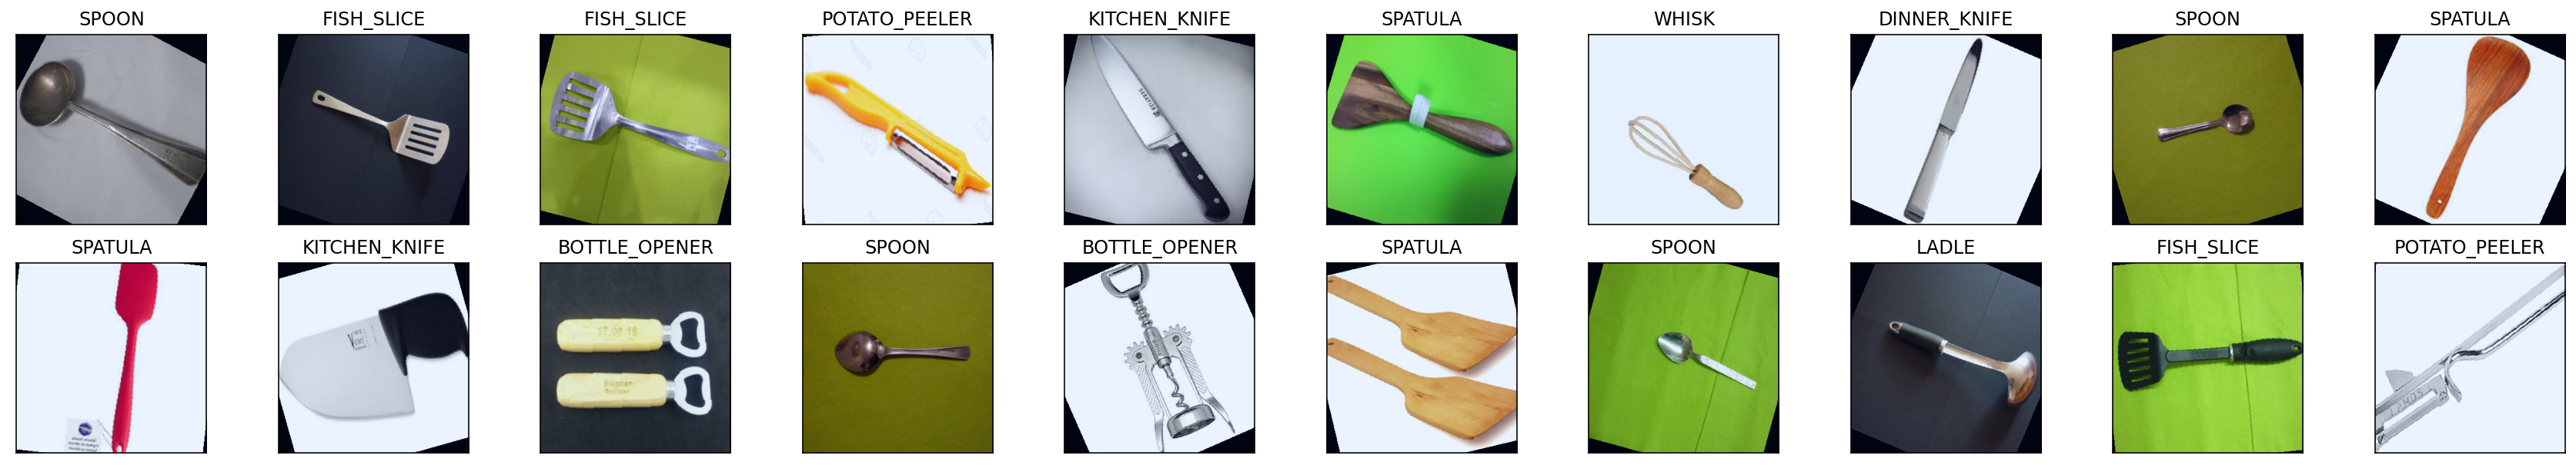

In [7]:
dataset_int.plot_training_images(num_images=20)

## Defining the Model

Our model will be a combination of the Inception-v3 for features extraction and a custom classifier.

### Pre-Trained Feature Extractor
We will rely on a pre-trained Inception-v3 model for the features extraction and thus apply transfer learning. Below we load this model from the pytorch library and freeze its parameters to ensure they are not re-trained. 

In [8]:
# Define already trained Inception-v3 model for learning transfer
model = models.inception_v3(pretrained=True, aux_logits=False)
# Disable gradient in the parameters of the model, since we don't want to train it again
for param in model.parameters():
    param.requires_grad = False

### Fully-Connected Layer for Classification
The last portion of the model is a set of fully-connected layers (FCLs). We do customize this portion for our specific task. The number of outputs in the final layer is determined by the number of classes (num_classes) variable defined above. The classifier has three fully-connected-layers that progressively down-sample the extracted features. A *ReLU* non-linearity is introduced after the first two layers as activation function. The final layer is a *Log Soft Max* which will provide the logarithm of the probabilities for each of the categories. The maximum number at this output can be used to determine the predicted category. 

In [9]:
model.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [10]:
# Define custom classifier as FCL
classifier = torch.nn.Sequential(OrderedDict([('fc1', torch.nn.Linear(2048, 1024)),
                                              ('relu1', torch.nn.ReLU()),
                                              ('drop1', torch.nn.Dropout(0.2)),
                                              ('fc2', torch.nn.Linear(1024, 512)),
                                              ('relu2', torch.nn.ReLU()),
                                              ('drop2', torch.nn.Dropout(0.2)),
                                              ('fc3', torch.nn.Linear(512, num_classes)),
                                              ('output', torch.nn.LogSoftmax(dim=1))
                                             ]))
    
# Override classifier in model with our custom FCL
model.fc = classifier

## Performing Training

In this section, we will execute the required steps to perform the training of our model. We will train our model for 75 epochs and an initial learning rate of 0.015 and that decays to 95% of its value in each epoch. 

In [11]:
# General Parameters for the training
n_epochs = 75
learning_rate=0.015
decay_rate = 0.95

Below we define a negative log likelihood criterion used to calculate the error as the training runs. A stochastic gradient descent (SGD) is utilized as an optimizer. The scueduler is used to automatically decay the learning rate after each epoch.

In [12]:
# Define criterion function for loss
criterion = torch.nn.NLLLoss()
# Use an Adam classifier to train parameters in classifier portion of the model (FCL)
# optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.fc.parameters(), lr=learning_rate, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate, verbose=True)

Adjusting learning rate of group 0 to 1.5000e-02.


Below we determine the device to use for training. Since we train this in collab, the expectation is having a CPU and then using 'cuda' as the device.

In [13]:
# Determine device to use for training (to use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device {}".format(device))

Using device cuda


Below we iterate over each of the epochs to perform the training process. We rely on the custom *training_helper.py* to do most of the work. For each epoch we perform training of the model and determine a loss (*train_loss*). We also use the validation chunk of the data to determine the loss for this set of images (*valid_loss*). Only when the validation loss decreases, we take a capture of the model and save it into a file. This is a good straategy to avoid overfitting and make sure the saved model is being able to generalize to the validation split only from looking at the training images.

In [14]:
# Init variables
start_time = time.time()
valid_loss_min = 1e9
train_loss_all = []
valid_loss_all = []
# Iterate for each of the epochs
for epoch in range(1, n_epochs+1):
    print("DEBUG: Starting epoch {}".format(epoch))
    # Perform training for this epoch and obtain its average loss
    train_loss, train_accuracy = training_helper.train_epoch(num_classes, optimizer, model, criterion, train_loader, device)
    train_loss_all.append(train_loss)
    
    # Perform validation for this epoch and obtain its average loss
    valid_loss, valid_accuracy = training_helper.validate_epoch(num_classes, model, criterion, valid_loader, device)
    valid_loss_all.append(valid_loss)

    # Let scheduler update learning rate for next epoch
    lr_scheduler.step()
    
    # Print loss for training and validation
    print('>> Epoch: {} \tTraining Loss: {:.5f} \tValidation Loss: {:.5f} \tTraining Accuracy: {:.2f}% \tValidation Accuracy: {:.2f}%'.format(epoch, train_loss, valid_loss, train_accuracy, valid_accuracy))
    
    # # Save model to disk only if validation loss hass decreased
    if valid_loss <= valid_loss_min:
        print('>>>>>>>> Validation loss decreased. Saving model!')
        torch.save(model.state_dict(), 'tl_inceptionv3_model.pt')
        valid_loss_min = valid_loss

# Finished training. Print elapsed time
end_time = time.time()
print(" =============== Finished Training, elapsed time: {} seconds ============== ".format(end_time-start_time))

DEBUG: Starting epoch 1
Adjusting learning rate of group 0 to 1.4250e-02.
>> Epoch: 1 	Training Loss: 2.30033 	Validation Loss: 2.29109 	Training Accuracy: 10.78% 	Validation Accuracy: 16.35%
>>>>>>>> Validation loss decreased. Saving model!
DEBUG: Starting epoch 2
Adjusting learning rate of group 0 to 1.3537e-02.
>> Epoch: 2 	Training Loss: 2.28967 	Validation Loss: 2.28048 	Training Accuracy: 15.00% 	Validation Accuracy: 16.98%
>>>>>>>> Validation loss decreased. Saving model!
DEBUG: Starting epoch 3
Adjusting learning rate of group 0 to 1.2861e-02.
>> Epoch: 3 	Training Loss: 2.26471 	Validation Loss: 2.24496 	Training Accuracy: 19.06% 	Validation Accuracy: 30.19%
>>>>>>>> Validation loss decreased. Saving model!
DEBUG: Starting epoch 4
Adjusting learning rate of group 0 to 1.2218e-02.
>> Epoch: 4 	Training Loss: 2.22970 	Validation Loss: 2.20137 	Training Accuracy: 30.00% 	Validation Accuracy: 44.65%
>>>>>>>> Validation loss decreased. Saving model!
DEBUG: Starting epoch 5
Adjustin

To understand how the training process went, below we generate a plot with the observed loss for the training and validation splits

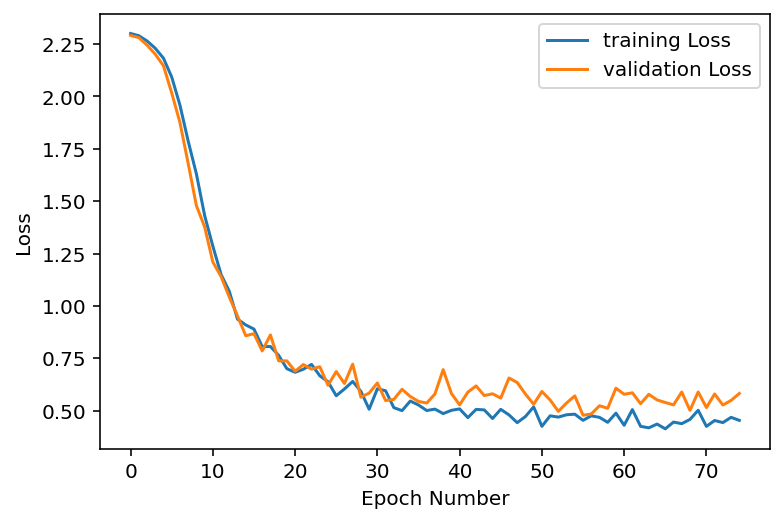

In [15]:
# Create plot to see progress in training and validation loss
plt.plot(train_loss_all, label="training Loss")
plt.plot(valid_loss_all, label="validation Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()

## Testing Model
Now we will use the saved model with the lowest validation loss to evaluate its predictions on the testing portion of the dataset. Below we load the saved coefficients for the trained model.

In [16]:
# Load best model
model.load_state_dict(torch.load('tl_inceptionv3_model.pt'))

<All keys matched successfully>

Below we perform an evaluation of the model on the test split of the data (whish is entirely new for the model), to determine its final loss and accuracy. 

In [17]:
# Run test evaluation and collect results dictionary
results = training_helper.test_eval(num_classes, model, criterion, test_loader, device)

# Print results
print('Test Loss: {:.5f}\n'.format(results['test_loss_avg']))
classes_results = results['classes_results']
for idx in range(num_classes):
    class_results = classes_results[idx]
    class_name = classes_names[idx]
    print("Class '{}'. Accuracy: {:.2f}% ({}/{})"
          .format(class_name, class_results['class_accuracy'], 
                  class_results['class_correct'], class_results['class_total']))

print('\nTest Accuracy (Global): {:.2f} %\n'.format(results['global_accuracy']))

Test Loss: 0.28971

Class 'BOTTLE_OPENER'. Accuracy: 100.00% (20.0/20.0)
Class 'DINNER_FORK'. Accuracy: 95.00% (19.0/20.0)
Class 'DINNER_KNIFE'. Accuracy: 85.00% (17.0/20.0)
Class 'FISH_SLICE'. Accuracy: 100.00% (20.0/20.0)
Class 'KITCHEN_KNIFE'. Accuracy: 90.00% (18.0/20.0)
Class 'LADLE'. Accuracy: 80.00% (16.0/20.0)
Class 'POTATO_PEELER'. Accuracy: 90.00% (18.0/20.0)
Class 'SPATULA'. Accuracy: 100.00% (20.0/20.0)
Class 'SPOON'. Accuracy: 100.00% (20.0/20.0)
Class 'WHISK'. Accuracy: 95.00% (19.0/20.0)

Test Accuracy (Global): 93.50 %

